In [1]:
#attempt to improve the NN
#add the local and the global view construct coz transit false positive mismatch seems to be a major problem
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [14]:
X_train=np.loadtxt('training_data/Xtrain_seg_mask.csv',delimiter=',')
M_train=np.loadtxt('training_data/Mtrain_seg_mask.csv',delimiter=',')
Y_train=np.loadtxt('training_data/Ytrain_seg_mask.csv',delimiter=',')
#I_train=np.loadtxt('training_data/Itrain_av_re.csv',delimiter=',')


#kernel_size = 3
#kernel = np.ones(kernel_size) / kernel_size
#X_train = np.array([np.convolve(X_train[i], kernel, mode='same') for i in range(len(X_train))])
#I_train = np.array([np.convolve(I_train[i], kernel, mode='same') for i in range(len(I_train))])


#I_train=np.array([[I_train[j,i] for i in range(0,len(I_train[0]),2)]    for j in range(len(I_train))])
#X_train=preprocessing.normalize(X_train)

In [15]:
'''
for i in range(0,len(X_train)):
    for j in range(0,4800):
        if(np.isnan(X_train[i][j])):
            X_train[i][j]=0

print(np.array(X_train).shape)'''

X_train=np.array([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in X_train])
#M_train=-M_train


In [17]:
Xtrain, Xtest, Ytrain, Ytest, Mtrain, Mtest = train_test_split(X_train, Y_train, M_train, test_size=0.2)
print(Xtrain.shape,Ytrain.shape,Xtest.shape,Ytest.shape, Mtrain.shape)
#Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_train, Y_train, test_size=0.2)
#print(Xtrain.shape,Ytrain.shape,Xtest.shape,Ytest.shape)

(1639, 4800) (1639, 2) (410, 4800) (410, 2) (1639, 4800)


In [41]:
np.random.seed(11223)

wt=[]
for el in Xtrain:
    med=np.median(el)
    min=el[np.argmin(el)]
    std=np.std(el)
    temp=(el-med)/(med-min)
    clean=[x for x in temp if x > med-std]
    wt.append(1/np.sqrt(np.std(clean)))

norm = np.linalg.norm(np.array(wt))
wt= 100*(np.array(wt)/norm)

print(wt.shape)

C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(1630,)


<function matplotlib.pyplot.show(close=None, block=None)>

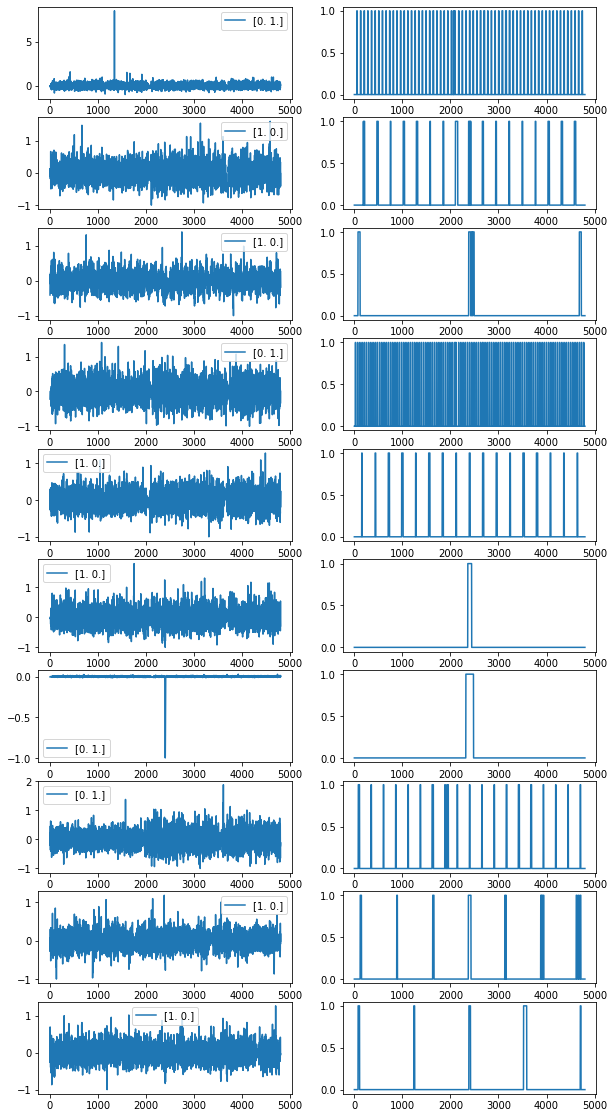

In [5]:

vararr=np.random.randint(0,len(Xtrain),size=10)
fig,ax=plt.subplots(10,2,figsize=(10,20))
for i in range(0,10):
    ax[i][0].plot(Xtrain[vararr[i]],label=Ytrain[vararr[i]])
    ax[i][1].plot(Mtrain[vararr[i]])
    ax[i][0].legend()
plt.show


In [46]:
IMG_SIZE=4800
#add hidden layers
conv_ip = keras.layers.Input(shape=(IMG_SIZE,),name='Input')
xi=keras.layers.Reshape((IMG_SIZE, 1), input_shape=(IMG_SIZE,),name='reshape_1')(conv_ip)
#xi=keras.layers.Cropping1D(cropping=(100, 100))(xi)
xi=keras.layers.BatchNormalization()(xi)

x1=keras.layers.Conv1D(16,kernel_size=3,strides=2,activation='tanh',padding='same',name='second_conv16_5')(xi)
c1=keras.layers.Conv1D(16,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv16_5')(x1)    #1600

x2=keras.layers.BatchNormalization()(c1)
x2=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_1')(x2)   #size 800,16
c2=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv32_5')(x2)

x3=keras.layers.BatchNormalization()(c2)
x3=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',padding='same',name='maxpool_2')(x3)    #size 400,32

m1=keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv128_5')(x3)
m2=keras.layers.Conv1D(128,kernel_size=3,strides=1,dilation_rate=2,activation='tanh',padding='same',name='first_conv128_5')(m1)
m3=keras.layers.Conv1D(128,kernel_size=3,strides=1,dilation_rate=2,activation='tanh',padding='same',name='second_conv128_5')(m2)
x4 = keras.layers.Concatenate(axis=1,name='midjoin')([m1,m2,m3])
x4=keras.layers.MaxPool1D(3,strides=3,data_format='channels_last',padding='same',name='maxpool_m')(x4)    

x4 = keras.layers.Conv1DTranspose(32, kernel_size=3, activation='tanh', padding="same", strides=2, name="decoder_conv_tran_1")(x4)
x4 =keras.layers.BatchNormalization()(x4)

x5 = keras.layers.Concatenate(axis=2)([c2,x4])
x5 = keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='relu',padding='same',name='dec_conv32_5')(x5)
x5 = keras.layers.Conv1DTranspose(8, kernel_size=3, activation='relu', padding="same", strides=2, name="decoder_conv_tran_3")(x5)
x5 = keras.layers.BatchNormalization()(x5)

x6 = keras.layers.Concatenate()([c1,x5]) #400
x6 = keras.layers.Conv1D(16,kernel_size=3,strides=1,activation='relu',padding='same',name='dec_conv8_5')(x6)
x6 = keras.layers.Conv1DTranspose(1,kernel_size=5,strides=2,padding='same',name='semiop',activation='sigmoid')(x6)

conv_op=keras.layers.Reshape((IMG_SIZE, ), input_shape=(IMG_SIZE,1),name='reshape_2')(x6)



#keras.backend.clear_session()
#convNN = keras.Model(inputs=[conv_ip,conv_ipl], outputs=conv_op,name='Convolutional_NN')
convNN = keras.Model(inputs=conv_ip, outputs=conv_op,name='Convolutional_NN')


convNN.summary()
convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005), loss='binary_crossentropy')

Model: "Convolutional_NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 4800)]       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 4800, 1)      0           Input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 4800, 1)      4           reshape_1[0][0]                  
__________________________________________________________________________________________________
second_conv16_5 (Conv1D)        (None, 2400, 16)     64          batch_normalization_57[0][0]     
___________________________________________________________________________________

In [7]:
'''
IMG_SIZE=6000
#add hidden layers
conv_ip = keras.layers.Input(shape=(IMG_SIZE,),name='Input')
xi=keras.layers.Reshape((IMG_SIZE, 1), input_shape=(IMG_SIZE,),name='reshape_1')(conv_ip)
#xi=keras.layers.Cropping1D(cropping=(100, 100))(xi)
xi=keras.layers.BatchNormalization()(xi)

x1=keras.layers.Conv1D(16,kernel_size=5,strides=3,activation='tanh',padding='same',name='second_conv16_5')(xi)
x1=keras.layers.Conv1D(16,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv16_5')(x1)
x1=keras.layers.BatchNormalization()(x1)
c1=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',padding='same',name='maxpool_1')(x1)   #size 1000

x2=keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv32_5')(c1)
x2=keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv32_5')(x2)
x2=keras.layers.BatchNormalization()(x2)
c2=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',padding='same',name='maxpool_2')(x2)    #size 500

ao = keras.layers.Conv1DTranspose(filters=32, kernel_size=3, activation='tanh', padding="same", strides=1, name="decoder_conv_tran_1")(c2)
ao = keras.layers.Conv1DTranspose(filters=32, kernel_size=3, activation='tanh', padding="same", strides=1, name="decoder_conv_tran_2")(ao)
ao=keras.layers.Flatten()(ao)
ao=keras.layers.Dense(200,activation='tanh',name='adding_this')(ao)

x3=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv64_5')(c2)
x3=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv64_5')(x3)
x3=keras.layers.BatchNormalization()(x3)
x3=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',padding='same',name='maxpool_3')(x3)    #size 250

x3=keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv128_5')(x3)
x3=keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv128_5')(x3)
x3=keras.layers.BatchNormalization()(x3)
x3=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',padding='same',name='maxpool_4')(x3)    #size 125


x3 = keras.layers.Conv1DTranspose(filters=64, kernel_size=3, activation='tanh', padding="same", strides=1, name="decoder_conv_tran_1")(x3)
x3 = keras.layers.Conv1DTranspose(filters=64, kernel_size=3, activation='tanh', padding="same", strides=1, name="decoder_conv_tran_2")(x3)

x3 = keras.layers.Conv1DTranspose(filters=32, kernel_size=3, activation='tanh', padding="same", strides=1, name="decoder_conv_tran_3")(x3)
x3 = keras.layers.Conv1DTranspose(filters=32, kernel_size=3, activation='tanh', padding="same", strides=1, name="decoder_conv_tran_4")(x3)
tx2 = keras.layers.Concatenate(axis=1)([c2,x3]) #size=400
tx2 = keras.layers.Conv1D(32,kernel_size=3,strides=2,activation='tanh',padding='same',name='maxpoolt_2')(tx2)
tx2=keras.layers.BatchNormalization()(tx2)

#tx2 = keras.layers.Conv1DTranspose(filters=16, kernel_size=5, activation='tanh', padding="same", strides=1, name="decoder_conv_tran_5")(tx2)
#tx2 = keras.layers.Conv1DTranspose(filters=16, kernel_size=5  , activation='tanh', padding="same", strides=1, name="decoder_conv_tran_6")(tx2)

tx2=keras.layers.Flatten()(x3)
tx2=keras.layers.Dense(128,activation='relu')(tx2)
tx2=keras.layers.Dense(128,activation='relu')(tx2)
tx2=keras.layers.Dense(1,activation='relu')(tx2)
conv_op=keras.layers.Dense(2,activation='softmax',name='missing_this')(tx2)



#convNN = keras.Model(inputs=[conv_ip,conv_ipl], outputs=conv_op,name='Convolutional_NN')
convNN = keras.Model(inputs=conv_ip, outputs=[ao,conv_op],name='Convolutional_NN')


convNN.summary()
convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000005), 
    loss={'missing_this': 'categorical_crossentropy','adding_this':keras.losses.Huber(delta=0.1)},metrics={'missing_this':'accuracy'})'''
print(' ')

In [49]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history=convNN.fit(np.array(Xtrain),np.array(Mtrain), batch_size=64, epochs=50, verbose=1, 
     validation_split=0.15)
#history=convNN.fit(np.array(Xtrain),[np.array(Itrain),np.array(Ytrain)], batch_size=64, epochs=70 , verbose=1 ,
#    shuffle=True,validation_split=0.2)

Epoch 1/50
22/22 [==============================] - 22s 977ms/step - loss: 0.2790 - val_loss: 0.2789
Epoch 2/50
22/22 [==============================] - 23s 1s/step - loss: 0.2782 - val_loss: 0.2779
Epoch 3/50
22/22 [==============================] - 23s 1s/step - loss: 0.2773 - val_loss: 0.2773
Epoch 4/50
22/22 [==============================] - 23s 1s/step - loss: 0.2764 - val_loss: 0.2770
Epoch 5/50
22/22 [==============================] - 23s 1s/step - loss: 0.2759 - val_loss: 0.2755
Epoch 6/50
22/22 [==============================] - 23s 1s/step - loss: 0.2751 - val_loss: 0.2754
Epoch 7/50
22/22 [==============================] - 23s 1s/step - loss: 0.2746 - val_loss: 0.2744
Epoch 8/50
22/22 [==============================] - 22s 1s/step - loss: 0.2740 - val_loss: 0.2737
Epoch 9/50
22/22 [==============================] - 22s 1s/step - loss: 0.2735 - val_loss: 0.2733
Epoch 10/50
22/22 [==============================] - 22s 1s/step - loss: 0.2731 - val_loss: 0.2726
Epoch 11/50
22/2

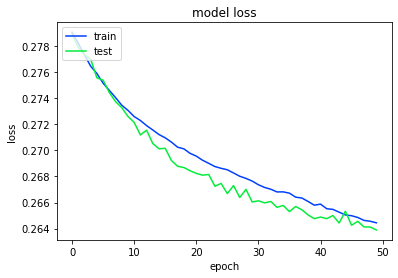

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('Mloss_SandN_raw500.png')
plt.show()

13/13 [==============================] - 2s 141ms/step - loss: 0.2829
0.28288590908050537
0.27605877394208395 0.31171686256079634


Text(0.5, 0, 'Phase')

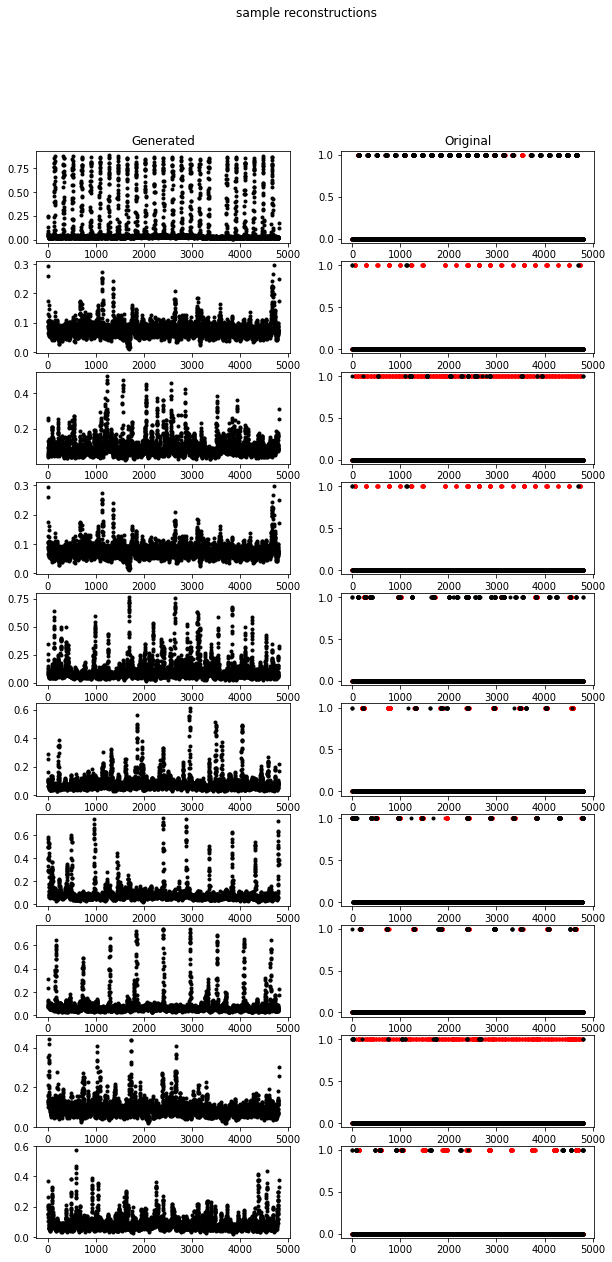

In [74]:
#test_loss, test_acc = convNN.evaluate(np.array(Xtest), np.array(Ytest))
#print('Test accuracy:', test_acc)
#Ypred_raw=convNN.predict(np.array(Xtest))
#Ypred=np.argmax(Ypred_raw, axis=1)
#Ytest_new=np.argmax(Ytest,axis=1)
#cm = confusion_matrix(Ytest_new, Ypred)
#print(cm)
from sklearn.metrics import mean_squared_error
pred_op=convNN.predict(np.array(Xtest))
val=mean_squared_error(pred_op, Mtest, squared=False)
print( convNN.evaluate(np.array(Xtest), np.array(Mtest)))
pred_op_mod=[]
for el in pred_op:
    #thres=np.median(el)+2*np.std(el)
    pred_op_mod.append([1 if x>0.25 else 0 for x in el])
pred_op_mod=np.array(pred_op_mod)
val2=mean_squared_error(pred_op_mod, Mtest, squared=False)

print(val,val2)
fig,ax=plt.subplots(10,2,figsize=(10,20))
plt.style.use('seaborn-bright')
plt.suptitle('sample reconstructions')
ar=np.random.randint(len(Xtest),size=10)
ax[0][0].set_title('Generated')
ax[0][1].set_title('Original')
for i in range(0,10):
    ax[i][0].plot(pred_op[ar[i]],color='black',ls='None',marker='.')
    ax[i][1].plot(Mtest[ar[i]],color='red',ls='None',marker='.')
    ax[i][1].plot(pred_op_mod[ar[i]],color='black',ls='None',marker='.')
    
    #ax[i][0].legend()
ax[4][0].set_xlabel('Phase')
ax[4][1].set_xlabel('Phase')



In [20]:
#new_Itrain,temp1=convNN.predict(np.array(Xtrain))
#new_Itest,temp2=convNN.predict(np.array(Xtest))
#print(new_Itrain.shape,new_Itest.shape)
#train_op= convNN.predict(Xtrain)
#train_op_mod=[]
#for el in train_op:
#    #thres=np.median(el)-2*np.std(el)
#    train_op_mod.append([1 if x>0.25 else 0 for x in el])
#train_op_mod=np.array(train_op_mod)
Itrain = -Mtrain * Xtrain
Itest = -Mtest * Xtest

<function matplotlib.pyplot.show(close=None, block=None)>

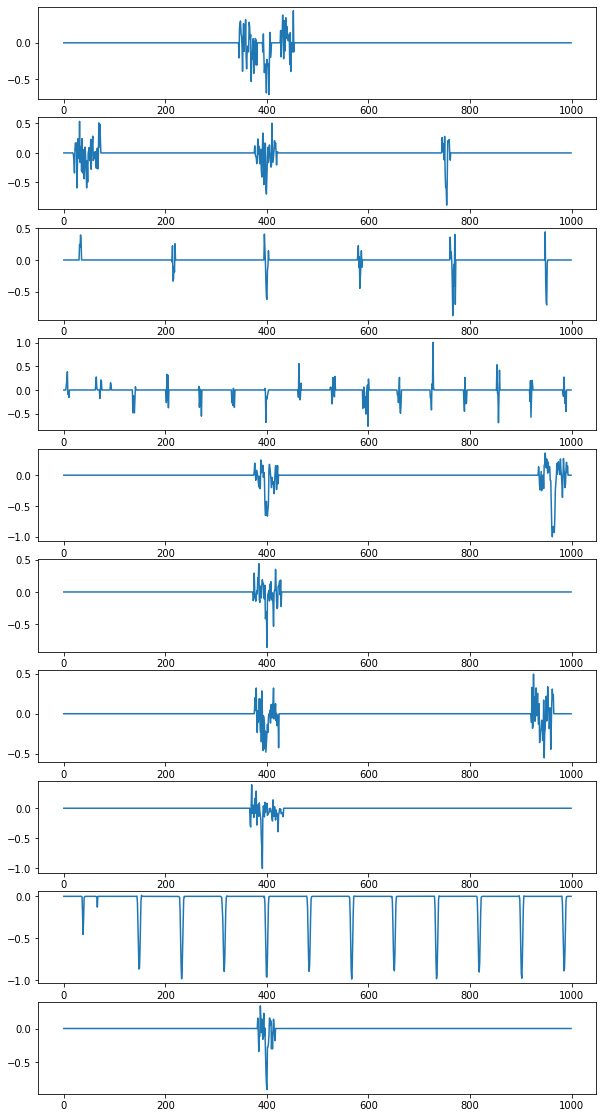

In [21]:

vararr=np.random.randint(0,len(Xtrain),size=10)
fig,ax=plt.subplots(10,1,figsize=(10,20))
for i in range(0,10):
    ax[i].plot( Itrain[vararr[i]][2000:3000],label=Ytrain[vararr[i]])
plt.show

In [34]:
IM_SIZE=4800
#add hidden layers
class_ip = keras.layers.Input(shape=(IM_SIZE,),name='Input')

m=keras.layers.Reshape((IM_SIZE, 1), input_shape=(IM_SIZE,),name='reshape_1')(class_ip)
m=keras.layers.BatchNormalization()(m)
m=keras.layers.Conv1D(16,kernel_size=3,strides=2,activation='tanh',padding='same',name='second_conv16_5')(m)
m=keras.layers.Conv1D(16,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv16_5')(m)

m=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_1')(m)
m=keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv32_5')(m)
m=keras.layers.Conv1D(32,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv32_5')(m)

m=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_2')(m)
m=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv64_5')(m)
m=keras.layers.Conv1D(64,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv64_5')(m)

m=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_4')(m)
m=keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv128_5')(m)
m=keras.layers.Conv1D(128,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv128_5')(m)

m=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_3')(m)
m=keras.layers.Flatten(name='flat_1')(m)
m=keras.layers.Dense(256,name='dense_layer_3',activation='relu')(m)
m=keras.layers.Dense(256,name='dense_layer_5',activation='relu')(m)
m=keras.layers.Dense(256,name='dense_layer_7',activation='relu')(m)
m=keras.layers.Dense(1,name='dense_layer_4',activation='relu')(m)
class_op=keras.layers.Dense(2,name='dense_layer_6',activation='softmax')(m)


#convNN = keras.Model(inputs=[conv_ip,conv_ipl], outputs=conv_op,name='Convolutional_NN')
classify = keras.Model(inputs=class_ip, outputs=class_op,name='Classifier_NN')


classify.summary()
classify.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000005), loss='categorical_crossentropy',metrics=['accuracy'])

Model: "Classifier_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 4800)]            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4800, 1)           0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 4800, 1)           4         
_________________________________________________________________
second_conv16_5 (Conv1D)     (None, 2400, 16)          64        
_________________________________________________________________
third_conv16_5 (Conv1D)      (None, 2400, 16)          784       
_________________________________________________________________
maxpool_1 (MaxPooling1D)     (None, 1200, 16)          0         
_________________________________________________________________
second_conv32_5 (Conv1D)     (None, 1200, 32)        

In [35]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#history=convNN.fit([np.array(Xtrain),np.array(Xtrainl)],np.array(Ytrain), batch_size=64, epochs=40, verbose=VERBOSE, validation_split=0.12,callbacks=[es_callback])
history2=classify.fit(np.array(Xtrain),np.array(Ytrain), batch_size=64, epochs=80 , verbose=1 , shuffle=True,validation_split=0.2)

Epoch 1/80
21/21 [==============================] - 9s 403ms/step - loss: 0.6933 - accuracy: 0.5385 - val_loss: 0.6931 - val_accuracy: 0.5335
Epoch 2/80
21/21 [==============================] - 8s 388ms/step - loss: 0.6930 - accuracy: 0.5721 - val_loss: 0.6930 - val_accuracy: 0.5579
Epoch 3/80
21/21 [==============================] - 8s 404ms/step - loss: 0.6919 - accuracy: 0.5957 - val_loss: 0.6922 - val_accuracy: 0.4848
Epoch 4/80
21/21 [==============================] - 9s 419ms/step - loss: 0.6908 - accuracy: 0.5385 - val_loss: 0.6914 - val_accuracy: 0.5579
Epoch 5/80
21/21 [==============================] - 9s 416ms/step - loss: 0.6889 - accuracy: 0.5957 - val_loss: 0.6902 - val_accuracy: 0.5366
Epoch 6/80
21/21 [==============================] - 9s 426ms/step - loss: 0.6868 - accuracy: 0.5637 - val_loss: 0.6889 - val_accuracy: 0.5427
Epoch 7/80
21/21 [==============================] - 9s 435ms/step - loss: 0.6850 - accuracy: 0.5919 - val_loss: 0.6884 - val_accuracy: 0.4939
Epoch 

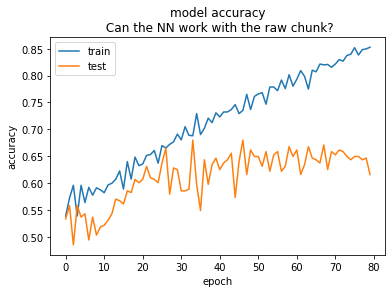

In [36]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy\n Can the NN work with the raw chunk?')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('rec_manual_mask.png')
plt.show()

In [27]:
test_loss, test_acc = classify.evaluate(np.array(Itest), np.array(Ytest))
print('Test accuracy:', test_acc)
Ypred_raw=classify.predict(np.array(Itest))
Ypred=np.argmax(Ypred_raw, axis=1)
Ytest_new=np.argmax(Ytest,axis=1)
cm = confusion_matrix(Ytest_new, Ypred)
print(cm)

13/13 [==============================] - 1s 59ms/step - loss: 0.6275 - accuracy: 0.7415
Test accuracy: 0.7414634227752686
[[159  53]
 [ 53 145]]
